In [1]:
# auto reload
%load_ext autoreload
%autoreload 2

import os
import ephem
import numpy as np
import imageio
import geopandas as gpd
from datetime import timedelta, datetime
from tqdm.auto import tqdm
from shapely.geometry import Point
from concurrent.futures import ProcessPoolExecutor

import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox

from sentinelhub import CRS

In [2]:
def get_shadow_length(long, lat, datetime, height):
    """
    Calculate length of the shadow
    """
    o = ephem.Observer()
    o.long, o.lat = str(long), str(lat)
    o.date = ephem.Date(datetime)
    sun = ephem.Sun(o)
    az = sun.az * 180/np.pi
    zen = 90 - sun.alt*180/np.pi
    shadow = 1 / np.tan(sun.alt)
    return shadow

def get_solar_data(long, lat, datetime, height):
    """
    Calculate length of the shadow, get also solar angles
    """
    o = ephem.Observer()
    o.long, o.lat = str(long), str(lat)
    o.date = ephem.Date(datetime)
    sun = ephem.Sun(o)
    az = sun.az * 180/np.pi
    zen = 90 - sun.alt*180/np.pi
    shadow = 1 / np.tan(sun.alt)
    return az, zen, shadow

In [3]:
# world geodataframe
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)

world.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [4]:
# calculate country centroids and the lengths of shadows for each country at 4 different dates
# cap negative lengtsh and lengths larger than 3 all to 3

wcoords = np.transpose([world.geometry.centroid.x.values, world.geometry.centroid.y.values])
mar_equi = datetime(2019, 3,20,12,0,0)
jun_sols = datetime(2019, 6,21,12,0,0)
sep_equi = datetime(2019, 9,23,12,0,0)
dec_sols = datetime(2019,12,22,12,0,0)

shadows3 = [get_shadow_length(long=c[0], lat=c[1], datetime=mar_equi, height=1) for c in wcoords]
shadows3 = np.array(shadows3)
shadows3[shadows3 < 0] = 3
shadows3[shadows3 > 3] = 3

shadows6 = [get_shadow_length(long=c[0], lat=c[1], datetime=jun_sols, height=1) for c in wcoords]
shadows6 = np.array(shadows6)
shadows6[shadows6 < 0] = 3
shadows6[shadows6 > 3] = 3

shadows9 = [get_shadow_length(long=c[0], lat=c[1], datetime=sep_equi, height=1) for c in wcoords]
shadows9 = np.array(shadows9)
shadows9[shadows9 < 0] = 3
shadows9[shadows9 > 3] = 3

shadows12 = [get_shadow_length(long=c[0], lat=c[1], datetime=dec_sols, height=1) for c in wcoords]
shadows12 = np.array(shadows12)
shadows12[shadows12 < 0] = 3
shadows12[shadows12 > 3] = 3

/home/mlubej/.pyenv/versions/3.7.6/envs/base/lib/python3.7/site-packages/geoplot/geoplot.py:680: UserWarning: Plot extent lies outside of the Orthographic projection's viewport. Defaulting to global extent.
  'Plot extent lies outside of the Orthographic projection\'s '
/home/mlubej/.pyenv/versions/3.7.6/envs/base/lib/python3.7/site-packages/geoplot/geoplot.py:625: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  extent = gpd.GeoSeries(self.extent) if self.extent is not None else None
/home/mlubej/.pyenv/versions/3.7.6/envs/base/lib/python3.7/site-packages/geoplot/geoplot.py:1793: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  return gpd.GeoSeries(var, index=df.inde

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

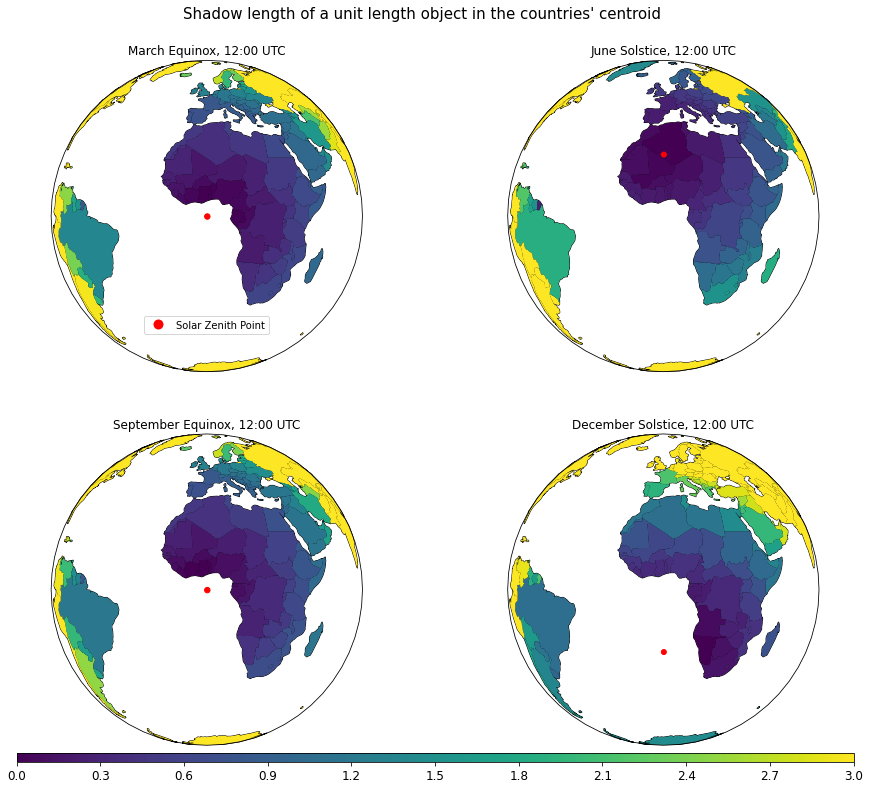

In [5]:
# plot the globe and the values of shadow lengths

fig, axs = plt.subplots(2,2,figsize=(15,15),
                        subplot_kw={'projection': gcrs.Orthographic()})

ax=axs[0][0]
geoplot.polyplot(world, ax=ax)
geoplot.choropleth(world,hue=shadows3, extent=(-180,-90,180,90),
                   projection=gcrs.Orthographic(), ax=ax)
tdf = gpd.GeoDataFrame(None, geometry=[Point([0,0])], crs=CRS.WGS84.epsg)
geoplot.choropleth(tdf.buffer(1),hue=['Solar Zenith Point'], color='r', cmap=plt.cm.autumn, extent=(-180,-90,180,90),
                   projection=gcrs.Orthographic(), ax=ax, legend=True, legend_kwargs={'loc': 'center', 'bbox_to_anchor':(0.5, 0.15)})
ax.set_title('March Equinox, 12:00 UTC')
ax.spines['geo'].set_visible(True)

ax=axs[0][1]
gplt = geoplot.polyplot(world, ax=ax)
geoplot.choropleth(world,hue=shadows6, extent=(-180,-90,180,90),
                   projection=gcrs.Orthographic(), ax=ax)
tdf = gpd.GeoDataFrame(None, geometry=[Point([0,23.45])], crs=CRS.WGS84.epsg)
geoplot.choropleth(tdf.buffer(1),hue=['Solar Zenith Point'], color='r', cmap=plt.cm.autumn, extent=(-180,-90,180,90),
                   projection=gcrs.Orthographic(), ax=ax)
ax.set_title('June Solstice, 12:00 UTC')
ax.spines['geo'].set_visible(True)

ax=axs[1][0]
gplt = geoplot.polyplot(world, ax=ax)
geoplot.choropleth(world,hue=shadows9, extent=(-180,-90,180,90),
                   projection=gcrs.Orthographic(), ax=ax)
tdf = gpd.GeoDataFrame(None, geometry=[Point([0,0])], crs=CRS.WGS84.epsg)
geoplot.choropleth(tdf.buffer(1),hue=['Solar Zenith Point'], color='r', cmap=plt.cm.autumn, extent=(-180,-90,180,90),
                   projection=gcrs.Orthographic(), ax=ax)
ax.set_title('September Equinox, 12:00 UTC')
ax.spines['geo'].set_visible(True)

ax=axs[1][1]
gplt = geoplot.polyplot(world, ax=ax)
geoplot.choropleth(world,hue=shadows12, extent=(-180,-90,180,90),
                   projection=gcrs.Orthographic(), ax=ax)
tdf = gpd.GeoDataFrame(None, geometry=[Point([0,-23.45])], crs=CRS.WGS84.epsg)
geoplot.choropleth(tdf.buffer(1),hue=['Solar Zenith Point'], color='r', cmap=plt.cm.autumn, extent=(-180,-90,180,90),
                   projection=gcrs.Orthographic(), ax=ax)
ax.set_title('December Solstice, 12:00 UTC')
ax.spines['geo'].set_visible(True)

sm = plt.cm.ScalarMappable()
sm._A = []
cb = fig.colorbar(sm, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=12) 
cb.set_ticks(np.arange(0,1.1,0.1))
cb.ax.set_xticklabels([f'{x:.1f}' for x in np.arange(0,3.3,0.3)]);

fig.suptitle("Shadow length of a unit length object in the countries' centroid", fontsize=15, y=0.93);
plt.savefig('figs/shadow_over_world.png', dpi=300, bbox_inches='tight')

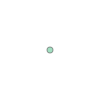

In [7]:
world[world.name == 'Slovenia'].geometry.centroid.values[0]

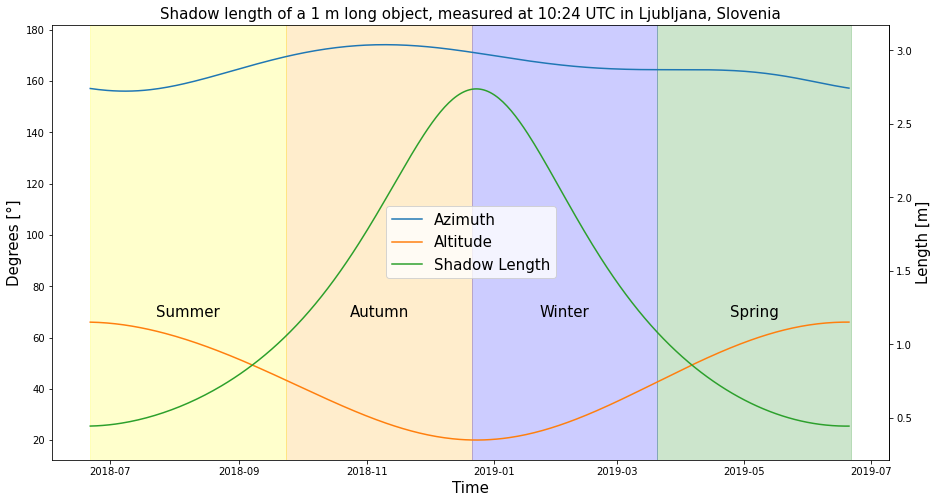

In [8]:
# plot evolution of shadow length and solar angles throughout the year

jun_sols = datetime(2018, 6,21,12,0,0)
sep_equi = datetime(2018, 9,23,12,0,0)
dec_sols = datetime(2018,12,21,12,0,0)
mar_equi = datetime(2019, 3,20,12,0,0)

dates = [jun_sols + timedelta(days=x, hours=-2, minutes=24) for x in range(0, 365)]
lon_lat_si = [14.50, 46.05]

data = np.array([get_solar_data(lon_lat_si[0], lon_lat_si[1], date, 1) for date in dates], dtype=float)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(1,1,figsize=(15,8))
plt.axvspan(jun_sols, sep_equi, alpha=0.2, color='yellow')
plt.axvspan(sep_equi, dec_sols, alpha=0.2, color='orange')
plt.axvspan(dec_sols, mar_equi, alpha=0.2, color='blue')
plt.axvspan(mar_equi, jun_sols+timedelta(days=365), alpha=0.2, color='green')

plt.text(jun_sols + (sep_equi-jun_sols)/2,70,'Summer',ha='center', va='center', fontsize=15)
plt.text(sep_equi + (dec_sols-sep_equi)/2,70,'Autumn',ha='center', va='center', fontsize=15)
plt.text(dec_sols + (mar_equi-dec_sols)/2,70,'Winter',ha='center', va='center', fontsize=15)
plt.text(mar_equi + (jun_sols+timedelta(days=365)-mar_equi)/2,70,'Spring',ha='center', va='center', fontsize=15)

plt.plot(dates,data[:,0],label='Azimuth')
plt.plot(dates,90-data[:,1],label='Altitude')
plt.plot(dates,data[:,2]*180/np.pi,label='Shadow Length')
plt.legend(fontsize=15, loc='center');
plt.xlabel('Time', fontsize=15)
plt.ylabel('Degrees [°]', fontsize=15)
plt.title('Shadow length of a 1 m long object, measured at 10:24 UTC in Ljubljana, Slovenia', fontsize=15)

def deg2rad(x):
    return x * np.pi / 180


def rad2deg(x):
    return x * 180 / np.pi

ax2 = ax.secondary_yaxis('right', functions=(deg2rad, rad2deg))
ax2.set_ylabel('Length [m]', fontsize=15);
plt.savefig('figs/seasons.png', dpi=300, bbox_inches='tight')

In [9]:
# function for plotting single time frame of a sketch

def plot_image(idx):
    global dates
    dtime = dates[idx]
    fig, ax = plt.subplots(1,1,figsize=(15,10), 
                           subplot_kw={'projection':'3d'})
    
    data = np.array([get_solar_data(lon_lat_si[0], lon_lat_si[1], date, 1) for date in dates], dtype=float)
    az, zen, sh = np.transpose(data)
    az = az*np.pi/180
    alt = np.pi/2 - zen*np.pi/180
    
    # draw analemma
    z = np.sin(alt)
    hyp = np.cos(alt)
    y = hyp*np.cos(az)
    x = hyp*np.sin(az)
    ax.plot(x,y,z,'b')
    
    # draw hemisphere
    phi,theta = np.linspace(0, 2*np.pi, 40), np.linspace(0, np.pi/2, 40)
    PHI, THETA = np.meshgrid(phi, theta)
    R = 1
    X = R * np.sin(THETA) * np.cos(PHI)
    Y = R * np.sin(THETA) * np.sin(PHI)
    Z = R * np.cos(THETA)
    plot = ax.plot_surface(
    X, Y, Z, antialiased=True, alpha=0.1,color ='w',linewidth=0)
    ax._axis3don = False
    
    # draw straight lines
    for i in range(2):
        th = np.linspace(-np.pi/2,np.pi/2,100)
        phi = np.zeros_like(th) + np.ones_like(th)*i*np.pi/2
        r = 1
        x = r * np.sin(th) * np.cos(phi)
        y = r * np.sin(th) * np.sin(phi)
        z = r * np.cos(th)
        ax.plot(x,y,z,color='k',alpha = 0.2)
        
    # draw stick
    Z = np.linspace(0,0.25,10)
    X,Y = np.zeros_like(Z),np.zeros_like(Z)
    ax.plot(X,Y,Z,'k')

    # draw shadow path
    phi = np.array(az)
    r = np.array(sh)*0.25
    x = -r * np.sin(phi)
    y = -r * np.cos(phi)
    ax.plot(x,y,'r',linewidth = 0.5)
    
    # draw sun path for day
    day = [dtime.replace(hour=0,minute=0)+timedelta(minutes=m) for m in range(24*60)]
    data = np.array([get_solar_data(lon_lat_si[0], lon_lat_si[1], d, 1) for d in day], dtype=float)
    az, zen, sh = np.transpose(data)
    az = az*np.pi/180
    alt = np.pi/2 - zen*np.pi/180
    mask = alt > 0
    alt = alt[mask]
    az = az[mask]
    
    z = np.sin(alt)
    hyp = np.cos(alt)
    y = hyp*np.cos(az)
    x = hyp*np.sin(az)
    ax.plot(x,y,z,color='k',alpha = 0.1)
    
    # draw sun at time
    az, zen, sh = get_solar_data(lon_lat_si[0], lon_lat_si[1], dtime, 1)
    az = az*np.pi/180
    alt = np.pi/2 - zen*np.pi/180
    
    z = np.sin(alt)
    hyp = np.cos(alt)
    y = hyp*np.cos(az)
    x = hyp*np.sin(az)
    ax.plot([x],[y],[z],'o', markersize=15, markerfacecolor='#ffff00',
             markeredgewidth=1.5, markeredgecolor='black')
    
    # draw shadow at time
    phi = np.array(az)
    r = np.array(sh)*0.25
    x = -r * np.sin(phi)
    y = -r * np.cos(phi)
    ax.plot([0,x],[0,y],'-',linewidth = 1, color = '#383838')
    
    # altidude
    th = np.linspace(0,np.pi/2,4)
    phi = -np.ones_like(th)*np.pi/2
    x = np.sin(th) * np.cos(phi)
    y = np.sin(th) * np.sin(phi)
    z = np.cos(th)
    coords = np.transpose([x,y,z])
    for c, t in zip(coords, th):
        ax.text(*c, f'{(90-t*180/np.pi):.0f}°', ha='center', va='center')
        
    # azimuth
    phi = np.linspace(0, np.pi, 7)
    th = -np.ones_like(phi)*np.pi/2
    x = np.sin(th) * np.cos(phi)
    y = np.sin(th) * np.sin(phi)
    z = np.cos(th)
    coords = np.transpose([x,y,z])
    for c, ph in zip(coords, phi[::-1]):
        ax.text(*c*1.05, f'{(90+ph*180/np.pi):.0f}°', ha='center', va='top')
    
    ax.elev=45
    ax.azim=-120
    ax.dist=7.5
    extent = Bbox([[4,1.1], [12,7.6]])
    
    plt.savefig(f'anims/anim_{idx}.png', dpi=125, transparent=False, bbox_inches=extent)
    plt.close()

In [10]:
# create animation

to_process = np.array(range(len(dates)))[::4]
    
os.system('rm -rf anims && mkdir anims')
with ProcessPoolExecutor(max_workers=8) as executor:
    _ = list(tqdm(executor.map(plot_image, to_process), total=len(to_process)))
    
with imageio.get_writer('figs/animation.gif', mode='I', duration=4.0/len(to_process)) as writer:
    for i in to_process:
        image = imageio.imread(f'anims/anim_{i}.png')
        writer.append_data(image)